In [1]:
import time
import random
import math
import itertools
from typing import List, Dict, Tuple, Optional, Any
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
# ==================== 1. ДАННЫЕ ВАРИАНТА ====================

# Глобальные константы
N_CITIES = 10
M_AGENTS = 4
START_CITIES = [0, 2, 4, 6]  # Точки старта агентов

# Матрица расстояний
DIST_MATRIX = [
    [0.00, 2.71, 2.67, 6.48, 0.32, 3.82, 3.47, 4.82, 6.41, 4.36],
    [2.71, 0.00, 2.17, 4.00, 2.61, 2.12, 1.85, 3.17, 3.88, 5.00],
    [2.67, 2.17, 0.00, 4.34, 2.37, 1.41, 3.97, 5.33, 4.35, 2.85],
    [6.48, 4.00, 4.34, 0.00, 6.27, 2.93, 5.03, 5.56, 0.27, 6.32],
    [0.32, 2.61, 2.37, 6.27, 0.00, 3.56, 3.53, 4.92, 6.21, 4.06],
    [3.82, 2.12, 1.41, 2.93, 3.56, 0.00, 3.90, 5.07, 2.95, 3.75],
    [3.47, 1.85, 3.97, 5.03, 3.53, 3.90, 0.00, 1.43, 4.84, 6.75],
    [4.82, 3.17, 5.33, 5.56, 4.92, 5.07, 1.43, 0.00, 5.32, 8.15],
    [6.41, 3.88, 4.35, 0.27, 6.21, 2.95, 4.84, 5.32, 0.00, 6.44],
    [4.36, 5.00, 2.85, 6.32, 4.06, 3.75, 6.75, 8.15, 6.44, 0.00]
]

# Параметры QUBO
A = 1000.0  # Большой штраф за нарушение ограничений
B = 1.0     # Вес целевой функции
L_MAX = N_CITIES - M_AGENTS + 1  # Максимальная длина маршрута

# Преобразуем данные в удобные форматы
dist_matrix_np = np.array(DIST_MATRIX, dtype=float)
cities = list(range(N_CITIES))
agents = list(range(M_AGENTS))

In [3]:
# ==================== 2. ОБЩИЕ ФУНКЦИИ ====================

def get_distance(u: int, v: int) -> float:
    """Возвращает расстояние между городами"""
    return DIST_MATRIX[u][v]

def calculate_route_length(route: List[int]) -> float:
    """Вычисляет длину маршрута (цикла)"""
    if len(route) < 2:
        return 0.0

    total = 0.0
    for i in range(len(route)):
        u = route[i]
        v = route[(i + 1) % len(route)]
        total += get_distance(u, v)
    return total

def calculate_makespan(routes: List[List[int]]) -> float:
    """Вычисляет makespan - максимальную длину маршрута"""
    if not routes:
        return float('inf')
    return max(calculate_route_length(route) for route in routes)

def calculate_total_length(routes: List[List[int]]) -> float:
    """Вычисляет общую длину всех маршрутов"""
    return sum(calculate_route_length(route) for route in routes)

def calculate_balance(routes: List[List[int]]) -> float:
    """Вычисляет коэффициент баланса (стандартное отклонение длин)"""
    if not routes:
        return float('inf')

    lengths = [calculate_route_length(route) for route in routes]
    if len(lengths) < 2:
        return 0.0

    mean_length = sum(lengths) / len(lengths)
    variance = sum((l - mean_length) ** 2 for l in lengths) / len(lengths)
    return math.sqrt(variance)

def is_valid_solution(routes: List[List[int]]) -> Tuple[bool, str]:
    """Проверяет допустимость решения"""
    # Проверяем, что все города посещены ровно один раз
    visited = set()
    for route in routes:
        for city in route:
            if city in visited:
                return False, f"Город {city} посещен более одного раза"
            visited.add(city)

    # Проверяем, что посещены все города
    if len(visited) != N_CITIES:
        missing = set(range(N_CITIES)) - visited
        return False, f"Не посещены города: {missing}"

    # Проверяем, что нет пустых маршрутов и что все агенты содержат стартовый город в своих маршрутах
    for i, route in enumerate(routes):
        if len(route) == 0:
            return False, f"Маршрут агента {i} пуст"
        if START_CITIES[i] not in route:
            return False, f"Маршрут агента {i} не проходит через его стартовый город"

    return True, "Решение допустимо"

In [4]:
# Функции для QUBO-представления
def solution_to_qubo(routes: List[List[int]]) -> np.ndarray:
    """Преобразует решение в QUBO-матрицу (n x L_MAX x m)"""
    x = np.zeros((N_CITIES, L_MAX, M_AGENTS), dtype=int)

    for k, route in enumerate(routes):
        for t, city in enumerate(route):
            if t < L_MAX:
                x[city, t, k] = 1

    return x

def qubo_to_solution(x: np.ndarray) -> List[List[int]]:
    """Преобразует QUBO-матрицу в решение (список маршрутов)"""
    routes = [[] for _ in range(M_AGENTS)]

    for k in range(M_AGENTS):
        for t in range(L_MAX):
            for city in range(N_CITIES):
                if x[city, t, k] == 1:
                    routes[k].append(city)

    return routes

def calculate_energy(x: np.ndarray) -> float:
    """Вычисляет полную энергию E_total для QUBO-представления"""
    # Штраф E1: каждый город посещается ровно один раз
    E1 = 0.0
    for u in range(N_CITIES):
        sum_xtk = np.sum(x[u, :, :])
        E1 += (1 - sum_xtk) ** 2
    E1 *= A

    # Штраф E2: в каждой позиции каждого маршрута не более одного города
    E2 = 0.0
    for k in range(M_AGENTS):
        for t in range(L_MAX):
            sum_ut = np.sum(x[:, t, k])
            E2 += sum_ut * (sum_ut - 1)
    E2 *= A

    # Штраф E3: каждый агент посещает хотя бы один город
    E3 = 0.0
    for k in range(M_AGENTS):
        sum_ut = np.sum(x[:, :, k])
        E3 += max(0, 1 - sum_ut) ** 2
    E3 *= A

    # Целевая функция E_obj: минимизация квадратов длин маршрутов
    E_obj = 0.0
    for k in range(M_AGENTS):
        Lk = 0.0
        # Суммируем расстояния между последовательными городами
        for t in range(L_MAX - 1):
            for u in range(N_CITIES):
                for v in range(N_CITIES):
                    if x[u, t, k] == 1 and x[v, t + 1, k] == 1:
                        Lk += get_distance(u, v)
        # Замыкаем цикл: последний город -> первый
        for u in range(N_CITIES):
            for v in range(N_CITIES):
                if x[u, L_MAX - 1, k] == 1 and x[v, 0, k] == 1:
                    Lk += get_distance(u, v)

        E_obj += Lk ** 2
    E_obj *= B

    return E1 + E2 + E3 + E_obj

In [5]:
# ==================== 3. АЛГОРИТМЫ ====================

def create_rand_solution() -> List[List[int]]:
    """Создает начальное допустимое решение"""

    # Создаем список всех городов, исключая стартовые
    remaining_cities = [c for c in range(N_CITIES) if c not in START_CITIES]
    random.shuffle(remaining_cities)

    # Начинаем с маршрутов, содержащих только стартовые города
    routes = [[start] for start in START_CITIES]

    # Распределяем оставшиеся города по кругу
    for i, city in enumerate(remaining_cities):
        routes[i % M_AGENTS].append(city)

    return routes

def create_greedy_solution() -> List[List[int]]:
    """выполняет жадный алгоритм"""

    # Начинаем с маршрутов, содержащих только стартовые города
    routes = [[start] for start in START_CITIES]

   # Список всех городов
    all_cities = list(range(N_CITIES))

    # Список еще не посещенных городов
    unvisited = [city for city in all_cities if city not in set(START_CITIES)]

    # Пока есть не посещенные города
    while unvisited:
        # Выбираем агента с минимальной текущей длиной маршрута
        agent_lengths = [calculate_route_length(route) for route in routes]
        min_agent_idx = min(range(M_AGENTS), key=lambda i: agent_lengths[i])

        # Получаем маршрут выбранного агента
        agent_route = routes[min_agent_idx]

        # Берем последний город в маршруте агента
        last_city = agent_route[-1]

        # Находим ближайший не посещенный город
        nearest_city = None
        min_distance = float('inf')

        for city in unvisited:
            dist = get_distance(last_city, city)
            if dist < min_distance:
                min_distance = dist
                nearest_city = city

        # Добавляем найденный город в маршрут агента
        agent_route.append(nearest_city)
        unvisited.remove(nearest_city)

    return routes

def two_opt_improvement(route):
    """Применяет 2-opt улучшения к маршруту"""

    best_route = route[:]
    best_length = calculate_route_length(route)
    improved = True
    iterations = 0

    while improved and iterations < 10:
        improved = False
        iterations += 1

        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route)):
                if j - i == 1:
                    continue

                # Пробуем перевернуть сегмент i..j
                new_route = route[:i] + route[i:j+1][::-1] + route[j+1:]
                new_length = calculate_route_length(new_route)

                if new_length < best_length:
                    best_route = new_route
                    best_length = new_length
                    improved = True

        route = best_route

    return best_route

In [6]:
# Имитация отжига (Simulated Annealing)
def simulated_annealing(
    seed: int,
    initial_temp: float = 100.0,
    cooling_rate: float = 0.95,
    min_temp: float = 0.001,
    max_iterations: int = 1000
) -> Dict[str, Any]:
    """
    Имитация отжига для решения mTSP-makespan

    Возвращает словарь с результатами:
    - makespan
    - total_length
    - balance
    - total_time
    - time_to_first_valid
    - time_to_best
    - is_valid
    - solution
    """
    random.seed(seed)
    np.random.seed(seed)
    start_time = time.time()

    # Инициализация жадным решением
    routes = create_greedy_solution()

    # Преобразуем в QUBO-представление
    current_x = solution_to_qubo(routes)
    current_energy = calculate_energy(current_x)

    # Лучшее решение
    best_routes = deepcopy(routes)
    best_makespan = calculate_makespan(routes)
    best_energy = current_energy

    # Временные метрики
    first_valid_time = None
    time_to_best = None

    # Проверяем начальное решение
    is_valid, _ = is_valid_solution(routes)
    if is_valid and first_valid_time is None:
        first_valid_time = time.time() - start_time

    # Процесс отжига
    temp = initial_temp

    for iteration in range(max_iterations):
        # Генерация соседнего состояния
        neighbor_x = current_x.copy()

        # Выбираем случайный способ изменения
        change_type = random.choice(['swap_within', 'swap_between', 'move', 'reverse'])

        if change_type == 'swap_within':
            # Обмен двух городов внутри одного маршрута
            k = random.randint(0, M_AGENTS - 1)
            if len(routes[k]) >= 3:
                i, j = random.sample(range(1, len(routes[k])), 2)
                routes[k][i], routes[k][j] = routes[k][j], routes[k][i]

        elif change_type == 'swap_between':
            # Обмен городов между двумя разными маршрутами
            k1, k2 = random.sample(range(M_AGENTS), 2)
            if len(routes[k1]) >= 2 and len(routes[k2]) >= 2:
                i = random.randint(1, len(routes[k1]) - 1)
                j = random.randint(1, len(routes[k2]) - 1)
                routes[k1][i], routes[k2][j] = routes[k2][j], routes[k1][i]

        elif change_type == 'move':
            # Перемещаем город из одного маршрута в другой
            from_k, to_k = random.sample(range(M_AGENTS), 2)
            if len(routes[from_k]) >= 2:
                city_idx = random.randint(1, len(routes[from_k]) - 1)
                city = routes[from_k].pop(city_idx)
                routes[to_k].append(city)

        elif change_type == 'reverse':
            # Разворачиваем часть маршрута
            k = random.randint(0, M_AGENTS - 1)
            if len(routes[k]) >= 3:
                i, j = sorted(random.sample(range(1, len(routes[k])), 2))
                routes[k][i:j+1] = reversed(routes[k][i:j+1])

        # Преобразуем в QUBO
        neighbor_x = solution_to_qubo(routes)
        neighbor_energy = calculate_energy(neighbor_x)

        # Вычисляем изменение энергии
        delta_energy = neighbor_energy - current_energy

        # Критерий принятия решения
        if delta_energy < 0 or random.random() < math.exp(-delta_energy / temp):
            current_x = neighbor_x
            current_energy = neighbor_energy

            # Проверяем допустимость
            is_current_valid, _ = is_valid_solution(routes)
            if is_current_valid:
                current_makespan = calculate_makespan(routes)

                if first_valid_time is None:
                    first_valid_time = time.time() - start_time

                # Обновляем лучшее решение
                if current_makespan < best_makespan:
                    best_makespan = current_makespan
                    best_routes = deepcopy(routes)
                    best_energy = current_energy
                    time_to_best = time.time() - start_time

        # Охлаждение
        temp *= cooling_rate
        if temp < min_temp:
            break

    total_time = time.time() - start_time

    # Если не нашли допустимое решение, используем лучшее по энергии
    if not best_routes:
        best_routes = qubo_to_solution(current_x)

    # Вычисляем финальные метрики
    is_valid_final, validity_msg = is_valid_solution(best_routes)
    if not is_valid_final:
        print(f"Не найдено валидное решение при seed={seed}: best_routes={best_routes} validity_msg={validity_msg}")

    result = {
        'makespan': calculate_makespan(best_routes),
        'total_length': calculate_total_length(best_routes),
        'balance': calculate_balance(best_routes),
        'total_time': total_time,
        'time_to_first_valid': first_valid_time if first_valid_time is not None else total_time,
        'time_to_best': time_to_best if time_to_best is not None else total_time,
        'is_valid': is_valid_final,
        'solution': best_routes
    }

    return result

In [7]:
# Поиск в больших окрестностях (Large NeighborhoodSearch, LNS)
def large_neighborhood_search(
    seed: int,
    destroy_percent: float = 0.4,
    inner_iterations: int = 100,
    lns_iterations: int = 50
) -> Dict[str, Any]:
    """
    Поиск в больших окрестностях (LNS)

    Возвращает словарь с результатами (формат такой же как у SA)
    """
    random.seed(seed)
    np.random.seed(seed)
    start_time = time.time()

    # Начальное решение: жадное распределение
    routes = create_greedy_solution()

    best_routes = deepcopy(routes)
    best_makespan = calculate_makespan(routes)

    # Временные метрики
    first_valid_time = time.time() - start_time
    time_to_best = first_valid_time

    remaining_cities = [c for c in range(N_CITIES) if c not in START_CITIES]
    n_destroy = max(1, int(round(len(remaining_cities) * destroy_percent)))
    # Основной цикл LNS
    for lns_iter in range(lns_iterations):
        # Фаза разрушения
        current_routes = deepcopy(routes)
        destroyed_cities = []

        # Выбираем случайные города для удаления
        cities_to_destroy = random.sample(remaining_cities, n_destroy)
        for city in cities_to_destroy:
            for k in range(M_AGENTS):
                if city in current_routes[k]:
                    current_routes[k].remove(city)
                    destroyed_cities.append(city)
                    break

        # Фаза восстановления (внутренний поиск)
        for inner_iter in range(inner_iterations):
            # Перемешиваем уничтоженные города
            random.shuffle(destroyed_cities)

            # Пытаемся вставить каждый город в лучшее место
            for city in destroyed_cities:
                best_agent = 0
                best_position = 1
                best_increase = float('inf')

                for k in range(M_AGENTS):
                    for pos in range(1, len(current_routes[k]) + 1):
                        test_route = current_routes[k][:pos] + [city] + current_routes[k][pos:]
                        new_length = calculate_route_length(test_route)
                        old_length = calculate_route_length(current_routes[k])
                        increase = new_length - old_length

                        if increase < best_increase:
                            best_increase = increase
                            best_agent = k
                            best_position = pos

                # Вставляем город в лучшее место
                current_routes[best_agent].insert(best_position, city)

            # Удаляем город из destroyed_cities после вставки
            destroyed_cities = []

            # Улучшаем маршруты с помощью 2-opt
            for k in range(M_AGENTS):
                current_routes[k] = two_opt_improvement(current_routes[k])

            # Проверяем новое решение
            current_makespan = calculate_makespan(current_routes)

            # Критерий принятия: принимаем если makespan улучшился
            if current_makespan < best_makespan:
                best_makespan = current_makespan
                best_routes = deepcopy(current_routes)
                time_to_best = time.time() - start_time

                # Переходим к новому решению
                routes = deepcopy(current_routes)
                break

    total_time = time.time() - start_time

    # Вычисляем финальные метрики
    is_valid_final, validity_msg = is_valid_solution(best_routes)

    result = {
        'makespan': best_makespan,
        'total_length': calculate_total_length(best_routes),
        'balance': calculate_balance(best_routes),
        'total_time': total_time,
        'time_to_first_valid': first_valid_time,
        'time_to_best': time_to_best,
        'is_valid': is_valid_final,
        'solution': best_routes
    }

    return result

In [8]:
# Жадный алгоритм + локальные улучшения (Baseline)
def greedy_with_local_search(
    seed: int,
    local_search_iterations: int = 100
) -> Dict[str, Any]:
    """
    Жадный алгоритм с локальными улучшениями

    Возвращает словарь с результатами (формат такой же как у SA)
    """
    random.seed(seed)
    np.random.seed(seed)
    start_time = time.time()

    # 1. Жадное построение начального решения
    routes = create_greedy_solution()

    # Временные метрики
    first_valid_time = time.time() - start_time
    best_routes = deepcopy(routes)
    best_makespan = calculate_makespan(routes)
    time_to_best = first_valid_time

    # 2. Локальные улучшения (2-opt для каждого маршрута)
    # Улучшаем каждый маршрут
    for k in range(M_AGENTS):
        routes[k] = two_opt_improvement(routes[k])

    # Обновляем лучшее решение
    current_makespan = calculate_makespan(routes)
    if current_makespan < best_makespan:
        best_makespan = current_makespan
        best_routes = deepcopy(routes)
        time_to_best = time.time() - start_time

    # 3. Балансировка: пытаемся переносить города между агентами
    for _ in range(local_search_iterations):
        # Выбираем случайного агента-донора и случайного агента-реципиента
        from_k, to_k = random.sample(range(M_AGENTS), 2)

        if from_k == to_k or len(routes[from_k]) <= 1:
            continue

        # Выбираем случайный город у донора
        city_idx = random.randint(1, len(routes[from_k]) - 1)
        city = routes[from_k].pop(city_idx)

        # Пробуем вставить в лучшее место у реципиента
        best_position = 1
        best_increase = float('inf')

        for pos in range(1, len(routes[to_k]) + 1):
            test_route = routes[to_k][:pos] + [city] + routes[to_k][pos:]
            new_length = calculate_route_length(test_route)
            old_length = calculate_route_length(routes[to_k])
            increase = new_length - old_length

            if increase < best_increase:
                best_increase = increase
                best_position = pos

        # Вставляем город
        routes[to_k].insert(best_position, city)

        # Улучшаем оба маршрута
        routes[from_k] = two_opt_improvement(routes[from_k])
        routes[to_k] = two_opt_improvement(routes[to_k])

        # Проверяем улучшение
        current_makespan = calculate_makespan(routes)
        if current_makespan < best_makespan:
            best_makespan = current_makespan
            best_routes = deepcopy(routes)
            time_to_best = time.time() - start_time

    total_time = time.time() - start_time

    # Вычисляем финальные метрики
    is_valid_final, validity_msg = is_valid_solution(best_routes)

    result = {
        'makespan': best_makespan,
        'total_length': calculate_total_length(best_routes),
        'balance': calculate_balance(best_routes),
        'total_time': total_time,
        'time_to_first_valid': first_valid_time,
        'time_to_best': time_to_best,
        'is_valid': is_valid_final,
        'solution': best_routes
    }

    return result

In [13]:
# ==================== 4. МНОГОКРАТНЫЙ ЗАПУСК ====================

def run_all_methods() -> Dict[str, List[Dict[str, Any]]]:
    """
    Запускает все методы на 10 разных seed'ах

    Возвращает словарь с результатами для каждого метода
    """
    seeds = list(range(10))

    results = {
        'simulated_annealing': [],
        'large_neighborhood_search': [],
        'greedy_with_local_search': []
    }

    print("Запуск имитации отжига (SA)...")
    for seed in seeds:
        result = simulated_annealing(
            seed=seed,
            initial_temp=400.0,
            cooling_rate=0.96,
            min_temp=0.001,
            max_iterations=1500
        )
        results['simulated_annealing'].append(result)

    print("Запуск поиска в больших окрестностях (LNS)...")
    for seed in seeds:
        result = large_neighborhood_search(
            seed=seed,
            destroy_percent=0.4,
            inner_iterations=30,
            lns_iterations=15
        )
        results['large_neighborhood_search'].append(result)

    print("Запуск жадного алгоритма с локальными улучшениями...")
    for seed in seeds:
        result = greedy_with_local_search(
            seed=seed,
            local_search_iterations=70
        )
        results['greedy_with_local_search'].append(result)

    return results

In [14]:
# ==================== 5. СТАТИСТИЧЕСКИЙ АНАЛИЗ ====================

def calculate_statistical_results(method_results: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Вычисляет средние значения по всем запускам одного метода

    Возвращает словарь со средними значениями
    """
    if not method_results:
        return {}

    # Вычисляем средние
    averages = {
        'avg_makespan': np.mean([r['makespan'] for r in method_results]),
        'min_makespan': np.min([r['makespan'] for r in method_results]),
        'avg_total_length': np.mean([r['total_length'] for r in method_results]),
        'avg_balance': np.mean([r['balance'] for r in method_results]),
        'avg_total_time': np.mean([r['total_time'] for r in method_results]),
        'avg_time_to_first_valid': np.mean([r['time_to_first_valid'] for r in method_results]),
        'avg_time_to_best': np.mean([r['time_to_best'] for r in method_results]),
        'validity_rate': np.mean([r['is_valid'] for r in method_results]) * 100,  # в процентах
        'num_runs': len(method_results)
    }

    return averages

In [15]:
# ==================== 6. ЗАПУСКАЕМ ВСЕ МЕТОДЫ ====================
all_results = run_all_methods()

Запуск имитации отжига (SA)...
Запуск поиска в больших окрестностях (LNS)...
Запуск жадного алгоритма с локальными улучшениями...


Число городов: 10
Число агентов: 4
Стартовые города: [0, 2, 4, 6]

РЕЗУЛЬТАТЫ (средние значения по всем запускам)

Метод: SIMULATED ANNEALING
----------------------------------------
Средний makespan: 10.6260
Минимальный makespan: 8.9700
Средняя общая длина: 33.0740
Средний баланс (стандартное отклонение): 2.0186
Среднее общее время: 0.3085 сек
Среднее время до первого допустимого: 0.0010 сек
Среднее время до лучшего: 0.2179 сек
Процент допустимых решений: 100.0%
Количество запусков: 10

Пример решения (seed=0):
  Агент 0: [0, 1, 5] (длина: 8.65)
  Агент 1: [2, 9] (длина: 5.70)
  Агент 2: [4, 7] (длина: 9.84)
  Агент 3: [6, 8, 3] (длина: 10.14)

Пример решения (seed=1):
  Агент 0: [0, 1] (длина: 5.42)
  Агент 1: [2, 5, 3] (длина: 8.68)
  Агент 2: [4, 9] (длина: 8.12)
  Агент 3: [6, 7, 8] (длина: 11.59)

Метод: LARGE NEIGHBORHOOD SEARCH
----------------------------------------
Средний makespan: 9.3000
Минимальный makespan: 8.9600
Средняя общая длина: 24.6160
Средний баланс (стандартное 

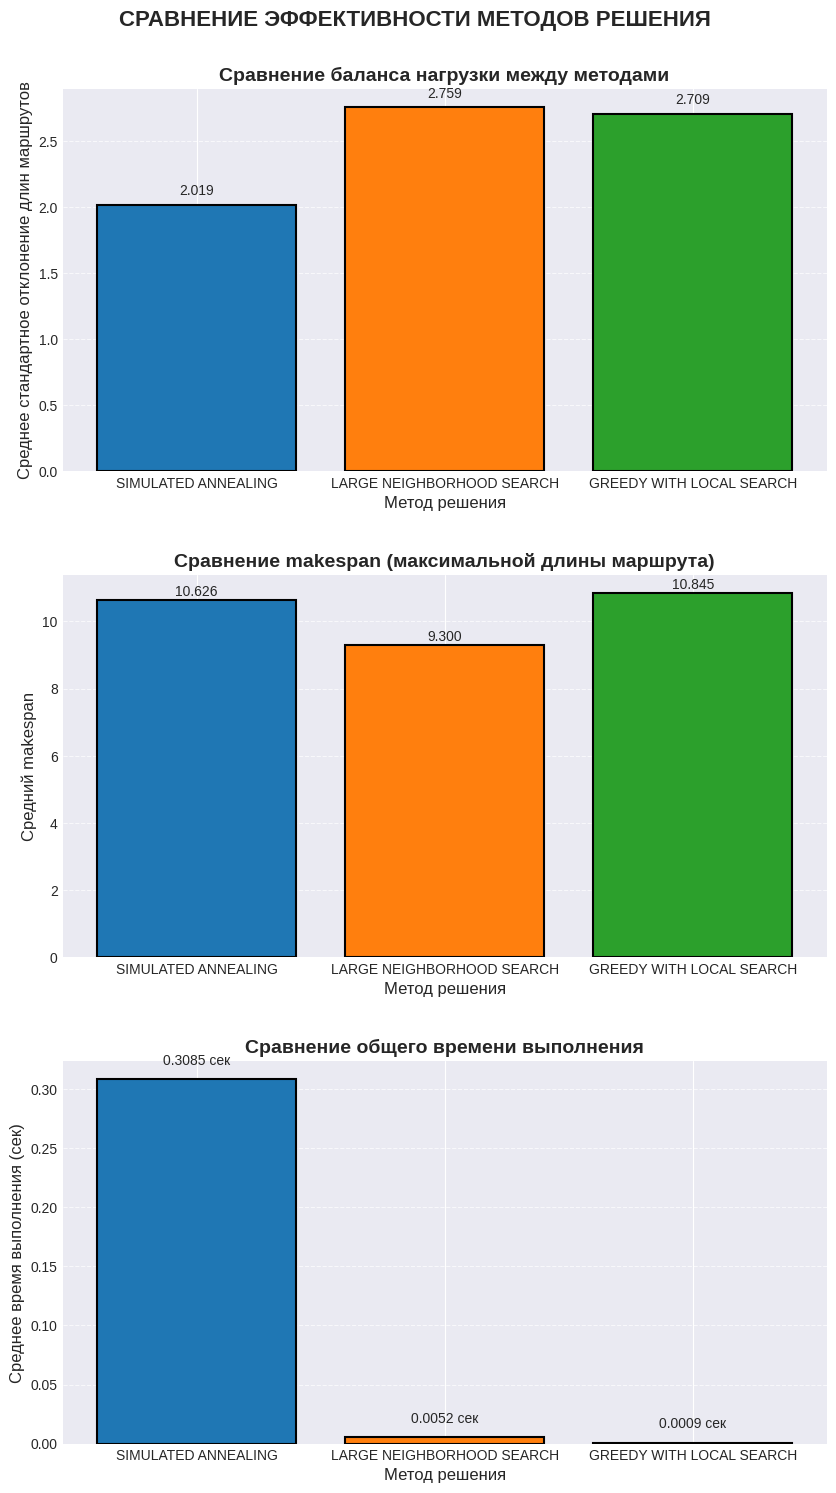

In [16]:
# ==================== 7. ВЫВОД И АНАЛИЗ РЕЗУЛЬТАТОВ ЗАПУСКА ====================

print(f"Число городов: {N_CITIES}")
print(f"Число агентов: {M_AGENTS}")
print(f"Стартовые города: {START_CITIES}")

# Вычисляем средние значения для каждого метода
print("\n" + "=" * 60)
print("РЕЗУЛЬТАТЫ (средние значения по всем запускам)")
print("=" * 60)

# Собираем данные для гистограмм
methods = []
avg_balances = []
avg_makespans = []
avg_total_times = []

for method_name, method_results in all_results.items():
    averages = calculate_statistical_results(method_results)

    print(f"\nМетод: {method_name.upper().replace('_', ' ')}")
    print("-" * 40)

    if averages:
        print(f"Средний makespan: {averages['avg_makespan']:.4f}")
        print(f"Минимальный makespan: {averages['min_makespan']:.4f}")
        print(f"Средняя общая длина: {averages['avg_total_length']:.4f}")
        print(f"Средний баланс (стандартное отклонение): {averages['avg_balance']:.4f}")
        print(f"Среднее общее время: {averages['avg_total_time']:.4f} сек")
        print(f"Среднее время до первого допустимого: {averages['avg_time_to_first_valid']:.4f} сек")
        print(f"Среднее время до лучшего: {averages['avg_time_to_best']:.4f} сек")
        print(f"Процент допустимых решений: {averages['validity_rate']:.1f}%")
        print(f"Количество запусков: {averages['num_runs']}")

        # Сохраняем данные для гистограмм
        methods.append(method_name.upper().replace('_', ' '))
        avg_balances.append(averages['avg_balance'])
        avg_makespans.append(averages['avg_makespan'])
        avg_total_times.append(averages['avg_total_time'])

    # Выводим одно из решений для примера
    if method_results:
        for seed in range(2):
            example_result = method_results[seed]
            print(f"\nПример решения (seed={seed}):")
            for k, route in enumerate(example_result['solution']):
                print(f"  Агент {k}: {route} (длина: {calculate_route_length(route):.2f})")

# Построение гистограмм

# Настройки стиля
plt.style.use('seaborn-v0_8-darkgrid')

# Создаем фигуру с тремя подграфиками
fig, axes = plt.subplots(3, 1, figsize=(9, 15))
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

# Цвета для методов
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# 1. Гистограмма баланса нагрузки
bars1 = ax1.bar(methods, avg_balances, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_title('Сравнение баланса нагрузки между методами', fontsize=14, fontweight='bold')
ax1.set_xlabel('Метод решения', fontsize=12)
ax1.set_ylabel('Среднее стандартное отклонение длин маршрутов', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Добавляем значения на столбцы
for bar, value in zip(bars1, avg_balances):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                f'{value:.3f}', ha='center', va='bottom', fontsize=10)

# 2. Гистограмма makespan
bars2 = ax2.bar(methods, avg_makespans, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_title('Сравнение makespan (максимальной длины маршрута)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Метод решения', fontsize=12)
ax2.set_ylabel('Средний makespan', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Добавляем значения на столбцы
for bar, value in zip(bars2, avg_makespans):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                f'{value:.3f}', ha='center', va='bottom', fontsize=10)

# 3. Гистограмма общего времени работы
bars3 = ax3.bar(methods, avg_total_times, color=colors, edgecolor='black', linewidth=1.5)
ax3.set_title('Сравнение общего времени выполнения', fontsize=14, fontweight='bold')
ax3.set_xlabel('Метод решения', fontsize=12)
ax3.set_ylabel('Среднее время выполнения (сек)', fontsize=12)
ax3.grid(axis='y', linestyle='--', alpha=0.7)

# Добавляем значения на столбцы
for bar, value in zip(bars3, avg_total_times):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.4f} сек', ha='center', va='bottom', fontsize=10)

# Настраиваем общий вид
plt.tight_layout(pad=3.0)

# Добавляем общий заголовок
fig.suptitle('СРАВНЕНИЕ ЭФФЕКТИВНОСТИ МЕТОДОВ РЕШЕНИЯ ',
            fontsize=16, fontweight='bold', y=1.01)

# Сохраняем график
plt.savefig('mtsp_comparison.png', dpi=150, bbox_inches='tight')

# Показываем график
plt.show()